## start

In [1]:
!pip install bayesian_optimization --quiet
!pip install ppscore --quiet
!pip install -q catboost
!pip install -q prince

%cd drive/MyDrive/buyer_time_pred/

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import prince
import string

from matplotlib import style
style.use('dark_background')
import ppscore as pps
#REgressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, VotingRegressor, AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from catboost import CatBoostRegressor

from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor, Dataset
from sklearn.ensemble import StackingRegressor
#from catboost import CatBoostRegressor
#Evalution Metrix
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

def pd_full():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    #pd.set_option('display.width', 2000)
    #pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)

def pd_reset():
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

/content/drive/MyDrive/buyer_time_pred


In [2]:
festive = '''1 Jan 2019
21 Mar 2019
15 Aug 2019
08 Oct 2019
27 Oct 2019
25 Dec 2019
29 Dec 2020
1 Jan 2020
10 Mar 2020
15 Aug 2020
25 Oct 2020
14 Nov 2020
25 Dec 2020
29 Dec 2020
'''

import datetime 

# t['Date'].to_pydatetime().date()
# t[['Date','Holiday']][t['Holiday']==True].head()

festive_list = []
range_list = []
for date in festive.splitlines():
    day, month_year = date.split(' ',1)
    range_list = [str(day)+' '+month_year for day in range(int(day)-2,int(day)+1) if int(day)>2]
    for date_range in range_list:
        date = datetime.datetime.strptime(date_range, '%d %b %Y') 
        if date.date() not in festive_list:
            festive_list.append(date.date())
            
def date_features(t, datecol):
    #t[datecol+'Year'] = t[datecol].dt.year
    #t[datecol+'Month'] = t[datecol].dt.month
    t['Day_of_week'] = t[datecol].dt.dayofweek
    t[datecol+'_Day'] = t[datecol].dt.day
    t[datecol+'_DayofYear'] = t[datecol].dt.dayofyear
    #t['Week'] = pd.to_datetime(t[datecol]).dt.week 
    #t['Quarter'] = pd.to_datetime(t[datecol]).dt.quarter
    #t['Is_year_start'] = t[datecol].dt.is_year_start
    #t['Is_year_end'] = t[datecol].dt.is_year_end
    #t['Is_month_start'] = np.where(pd.to_datetime(t[datecol]).dt.is_month_start,1,0) 
    #t['Is_month_end'] = np.where(pd.to_datetime(t[datecol]).dt.is_month_end,1,0)
    #t['Is_weekend'] = np.where(t['Day_of_week'].isin([5,6]),1,0)
    #t['Is_Holiday'] = np.where(t[datecol].isin(festive_list),1,0)
    del t[datecol]
    return t 

def top_k_encoding(col,k):
   topklist = t[col].value_counts().index[:k].tolist() 
   for ver in topklist:
       t[col] = [ver if ver in ele else "other" for ele in t[col]]

def client_agent_proc(x, agt):
    for i in range(len(x)):
        if agt in x[i]:
            return x[i]

# t['client_agent'].apply(type).value_counts()


# def device_details(x):
#     if 'iPhone' in x:
#         return 'IPhone'
#     elif 'Android' in x:
#         return 'Android'
#     elif 'Desktop' in x:
#         return 'Desktop'
#     elif 'iPad' in x:
#         return 'iPad'
#     else:
#         return 'Other'

# from collections import Counter
# import string
# import re
# device_gran = t["client_agent"].iloc[0].lower().translate(str.maketrans('', '', string.punctuation)).split()
# t['client_agent'].str.split(expand=True).stack().value_counts()
# d = pd.DataFrame(t["client_agent"].str.lower().str.translate(str.maketrans('', '', string.punctuation)).str.split(' ',-1, expand=True))
# t["client_agent"].str.lower().str.translate(str.maketrans('', '', string.punctuation)).str.split().iloc[:20]
# t["client_agent"].str.lower().str.translate(str.maketrans('', '', string.punctuation)).str.split()

def client_agent(x):
    if 'iPhone' in str(x):
            return 'IPhone'
    elif 'Windows' in str(x):
        return 'Windows'
    elif 'Mac OS X' in str(x):
        return 'Mac'
    elif 'Android' in str(x):
        return 'Android'
    elif 'Linux' in str(x):
        return 'Linux'
    else:
        return 'Other'

# def mergedevice(x):
#     if x['client_agent']!=x['device_details']:
#         return x['client_agent']+x['device_details']
#     return x['client_agent']

def kfold_opt_cv(trn, target, test_set, estimator, n_splits=5, shuffle_val=False, featimp=False):
    featimp_list = []
    add = 0
    splits = n_splits
    target = np.log1p(target)
    oof_pred = oof_preds = np.zeros(len(test_set))
    if shuffle_val:
        kfold, scores = KFold(n_splits=splits,shuffle=shuffle_val), list()
    else:
        kfold, scores = KFold(n_splits=splits,random_state=42), list()
    for train, test in kfold.split(trn,target):
        x_train, x_test = trn.values[train], trn.values[test]
        y_train, y_test = target.values[train], target.values[test]
        model = estimator
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        preds = np.expm1(preds)
        oof_pred = model.predict(test_set)
        oof_preds += np.expm1(oof_pred)

        if featimp:
            feature_importances = pd.DataFrame(model.feature_importances_,
                                            index = trn.columns,
                                            columns=['importance'])
            featimp_list.append(feature_importances.values)

        score = np.sqrt(mean_squared_log_error(np.expm1(y_test), preds))
        scores.append(score)
        print("Score is", score)

    oof_preds = oof_preds/splits
    print("Average:", np.sum(scores)/len(scores))
    if featimp:
        for item in featimp_list:
            add+=item
        df_cv=pd.DataFrame(add/len(featimp_list),index=trn.columns,columns=["importance"]).sort_values('importance', ascending=False)
        display(df_cv)
    return oof_preds

def kfold_cv(trn, target, estimator_name, estimator, n_splits=5, shuffle_val=False, featimp=False):
    featimp_list = []
    add = 0
    splits = n_splits
    target = np.log1p(target)
    if shuffle_val:
        kfold, scores = KFold(n_splits=splits,shuffle=shuffle_val), list()
    else:
        kfold, scores = KFold(n_splits=splits, shuffle=shuffle_val, random_state=42), list()
    for train, test in kfold.split(trn,target):
        x_train, x_test = trn.values[train], trn.values[test]
        y_train, y_test = target.values[train], target.values[test]
        model = estimator
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        preds = np.expm1(preds)

        if featimp:
            feature_importances = pd.DataFrame(model.feature_importances_,
                                            index = trn.columns,
                                            columns=['importance'])
            featimp_list.append(feature_importances.values)

        score = np.sqrt(mean_squared_log_error(np.expm1(y_test), preds))
        scores.append(score)
        #print("RMSLE Score is", score)

    print(f"Average of model {estimator_name} is {np.sum(scores)/len(scores)} and per fold scores are {scores}")
    if featimp:
        for item in featimp_list:
            add+=item
        df_cv=pd.DataFrame(add/len(featimp_list),index=trn.columns,columns=["importance"]).sort_values('importance', ascending=False)
        display(df_cv)
    return estimator_name, np.sum(scores)/len(scores)

def rmsle_lgbm(y_pred, data):

    y_true = np.array(data.get_label())
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

    return 'rmsle', score, False

## rest

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/buyer_time_pred/ParticipantData_BTPC/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/buyer_time_pred/ParticipantData_BTPC/Test.csv')
df_train.drop('session_id', axis=1, inplace=True)
df_test.drop('session_id', axis=1, inplace=True)

5429 5374


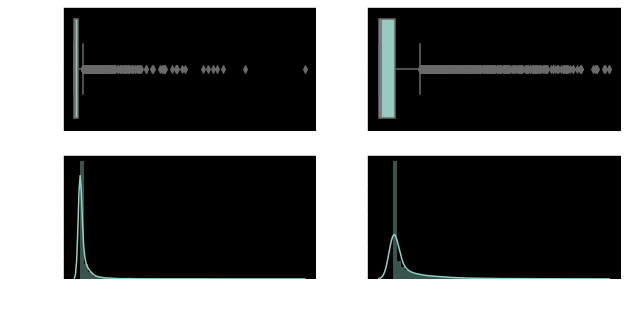

In [4]:
#upper_lim = df_train['time_spent'].mean() + df_train['time_spent'].std() * 3
upper_lim = df_train['time_spent'].quantile(.99)
df_train_copy = df_train[(df_train['time_spent'] < upper_lim)]
print(df_train.shape[0], df_train_copy.shape[0])
fig, ax = plt.subplots(2,2, figsize=(10,5))
axis = ax.flatten()
sns.boxplot(df_train.time_spent, ax = axis[0]);
sns.boxplot(df_train_copy.time_spent, ax=axis[1]);
sns.distplot(df_train.time_spent, ax = axis[2]);
sns.distplot(df_train_copy.time_spent, ax=axis[3]);
df_train = df_train[(df_train['time_spent'] < upper_lim)]

In [5]:
df_train.shape

(5374, 8)

## FE

In [27]:
t = pd.concat([df_train.drop('time_spent', axis=1), df_test], ignore_index=True)

#t[['device','browser']] = t['device_details'].str.split('-', expand=True)
# t.drop(['device_details'], axis=1, inplace=True)

t['date'] = pd.to_datetime(t['date'])
t['diff_date'] = ((t['date'] - pd.datetime(2019,1,1)).dt.total_seconds())/(10**6)

# t['pur_addedincart'] = t['purchased'] & t['added_in_cart']
# t['checkout_addedincart'] = t['checked_out'] & t['added_in_cart']
# t['checkout_pur'] = t['checked_out'] & t['purchased']
t['pur_ac_ch'] = t['purchased'] + t['added_in_cart'] + t['checked_out'] 

t = date_features(t,'date')

######### CLIENT AGENT PROC ################

t['client_agent'] = t["client_agent"].str.lower().str.translate(str.maketrans('', '', string.punctuation)).str.split()
t['client_agent'] = t['client_agent'].fillna('None')

client_agt_lst = ['mozilla','apple','windows','mac','chrome','safari', 'linux','iphone','ipad','android']
for agt in client_agt_lst:
    t[agt+'ver'] = t['client_agent'].apply(lambda x:client_agent_proc(x, agt))
t.drop(['client_agent'], axis=1, inplace=True)

t.drop(['safariver','linuxver','ipadver','macver','windowsver'], axis=1, inplace=True)
ver_cols = [col for col in t.columns if 'ver' in col]
t[ver_cols] = t[ver_cols].fillna('None')

mca_t = prince.MCA(random_state=42).fit_transform(t[ver_cols])
mca_t.columns = ['mca_1','mca_2']
t = pd.concat([mca_t,t],axis=1)

t.drop(ver_cols, axis=1, inplace=True)

#############################################

############## Binning ######################

# t['session_number_q20'] = pd.qcut(t['session_number'], q=100, precision=0, duplicates='drop', labels=False)
# t.drop(['session_number'], axis=1, inplace=True)

#############################################

#t.client_agent = t.client_agent.apply(client_agent)

####### GROUPING FEATURES ########

grouped = t.groupby(['pur_ac_ch']).agg({'session_number': ['nunique','mean'],
                                        'diff_date': ['mean','min','max'], 
                                        'Day_of_week': ['mean'],
                                        'date_Day': ['mean'],
                                        'date_DayofYear': ['mean'],
                                        'device_details': ['nunique'],
                                        })

grouped2 = t.groupby(['device_details']).agg({'session_number': ['nunique','mean'],
                                        'diff_date': ['mean','min','max'], 
                                        'Day_of_week': ['mean'],
                                        'date_Day': ['mean'],
                                        'date_DayofYear': ['mean'],
                                        })

grouped.columns = ['grpbypur_ac_ch' + '_'.join(c).strip('_') for c in grouped.columns]
grouped2.columns = ['grpbydevice' + '_'.join(c).strip('_') for c in grouped2.columns]

t = pd.merge(t, grouped, on = ['pur_ac_ch'], how='left')
t = pd.merge(t, grouped2, on = ['device_details'], how='left')

In [7]:
t.head()

,mca_1,mca_2,session_number,device_details,purchased,added_in_cart,checked_out,diff_date,pur_ac_ch,Day_of_week,date_Day,date_DayofYear,grpbypur_ac_chsession_number_nunique,grpbypur_ac_chsession_number_mean,grpbypur_ac_chdiff_date_mean,grpbypur_ac_chdiff_date_min,grpbypur_ac_chdiff_date_max,grpbypur_ac_chDay_of_week_mean,grpbypur_ac_chdate_Day_mean,grpbypur_ac_chdate_DayofYear_mean,grpbypur_ac_chdevice_details_nunique,grpbydevicesession_number_nunique,grpbydevicesession_number_mean,grpbydevicediff_date_mean,grpbydevicediff_date_min,grpbydevicediff_date_max,grpbydeviceDay_of_week_mean,grpbydevicedate_Day_mean,grpbydevicedate_DayofYear_mean
0,1.147234,0.413352,715,Desktop - Chrome,1,0,0,33.3504,1,2,22,22,340,795.127670,27.076556,10.8864,41.2128,2.818413,15.384028,198.165310,16,200,543.205607,27.452077,11.6640,40.9536,2.893798,14.975361,207.092608
1,-0.847062,0.275022,55,iPhone - iOS,1,0,0,36.4608,1,3,27,58,340,795.127670,27.076556,10.8864,41.2128,2.818413,15.384028,198.165310,16,519,1520.227122,27.156802,11.0592,40.6944,2.946894,15.532480,207.320531
2,0.308249,-1.235720,11,iPhone - MobileWeb,0,0,0,18.3168,0,3,1,213,657,1200.133958,26.211493,10.7136,41.2992,2.963433,15.425946,213.760933,17,253,1697.194379,23.069205,12.8736,40.4352,3.168618,15.388759,235.522248
3,0.022664,0.009351,2794,Desktop - IE,0,1,0,31.3632,1,0,30,364,340,795.127670,27.076556,10.8864,41.2128,2.818413,15.384028,198.165310,16,207,856.995316,27.136682,10.9728,41.2128,2.770492,16.325527,178.313817
4,0.308249,-1.235720,3674,iPhone - Web,0,0,0,21.7728,0,1,10,253,657,1200.133958,26.211493,10.7136,41.2992,2.963433,15.425946,213.760933,17,430,1871.333691,27.342448,11.9232,40.4352,3.154506,15.672747,239.920601


In [28]:
encode_cols = ['device_details'] 

from sklearn.preprocessing import LabelEncoder
t[encode_cols] = t[encode_cols].apply(LabelEncoder().fit_transform)

trn = t[:df_train.shape[0]]
tst = t[df_train.shape[0]:]
y = df_train.time_spent

trn = trn.reset_index(drop=True)
tst = tst.reset_index(drop=True)
y = y.reset_index(drop=True)

print(trn.shape, y.shape, tst.shape)

trn = pd.concat([trn, y], axis=1)

(5374, 29) (5374,) (2327, 29)


In [29]:
## Session Number
trn["SessionNo_MeanBuyerTime"] = trn.groupby(['session_number'])['time_spent'].transform('mean')
sessionNo_mean_dict = trn.groupby(['session_number'])['time_spent'].mean().to_dict()
tst['SessionNo_MeanBuyerTime'] = tst['session_number'].apply(lambda x:sessionNo_mean_dict.get(x,0))

trn["SessionNo_MinBuyerTime"] = trn.groupby(['session_number'])['time_spent'].transform('min')
sessionNo_min_dict = trn.groupby(['session_number'])['time_spent'].min().to_dict()
tst['SessionNo_MinBuyerTime'] = tst['session_number'].apply(lambda x:sessionNo_min_dict.get(x,0))

trn["SessionNo_MaxBuyerTime"] = trn.groupby(['session_number'])['time_spent'].transform('max')
sessionNo_max_dict = trn.groupby(['session_number'])['time_spent'].max().to_dict()
tst['SessionNo_MaxBuyerTime'] = tst['session_number'].apply(lambda x:sessionNo_max_dict.get(x,0))

## Device Details

trn["DeviceDeatails_MeanBuyerTime"] = trn.groupby(['device_details'])['time_spent'].transform('mean')
devicedetails_mean_dict = trn.groupby(['device_details'])['time_spent'].mean().to_dict()
tst['DeviceDeatails_MeanBuyerTime'] = tst['device_details'].apply(lambda x:devicedetails_mean_dict.get(x,0))

trn["DeviceDeatails_MinBuyerTime"] = trn.groupby(['device_details'])['time_spent'].transform('min')
devicedetails_min_dict = trn.groupby(['device_details'])['time_spent'].min().to_dict()
tst['DeviceDeatails_MinBuyerTime'] = tst['device_details'].apply(lambda x:devicedetails_min_dict.get(x,0))

trn["DeviceDeatails_MaxBuyerTime"] = trn.groupby(['device_details'])['time_spent'].transform('max')
devicedetails_max_dict = trn.groupby(['device_details'])['time_spent'].max().to_dict()
tst['DeviceDeatails_MaxBuyerTime'] = tst['device_details'].apply(lambda x:devicedetails_max_dict.get(x,0))

trn["devicedetails_count"] = trn.groupby(['device_details'])['device_details'].transform('count')
devicedetails_count_dict = trn.groupby(['device_details']).size().to_dict()
tst['devicedetails_count'] = tst['device_details'].apply(lambda x:devicedetails_count_dict.get(x,0))

In [30]:
trn.drop(['time_spent'], axis=1, inplace=True)

In [11]:
print(trn.shape, tst.shape)

(5374, 32) (2327, 32)


In [12]:
trncopy = trn.copy()
ss = StandardScaler()
trn  = ss.fit_transform(trn)
tst = ss.transform(tst)
trn = pd.DataFrame(trn, columns = trncopy.columns)
tst = pd.DataFrame(tst, columns = trncopy.columns)

## RFECV

In [31]:
from sklearn.feature_selection import RFECV, RFE
estimator = DecisionTreeRegressor()
n_features_to_select = (2*len(trn.columns))//3
# n_features_to_select = 15
rfecv = RFE(estimator=estimator, n_features_to_select=n_features_to_select,step=5)
rfecv = rfecv.fit(trn, np.log1p(y))
print('Optimal Features', rfecv.n_features_)
print('Best Features', trn.columns[rfecv.support_])

Optimal Features 24
Best Features Index(['mca_1', 'mca_2', 'session_number', 'device_details', 'purchased',
       'diff_date', 'Day_of_week', 'date_Day', 'date_DayofYear',
       'grpbypur_ac_chdiff_date_mean', 'grpbydevicesession_number_nunique',
       'grpbydevicediff_date_mean', 'grpbydevicediff_date_min',
       'grpbydevicediff_date_max', 'grpbydeviceDay_of_week_mean',
       'grpbydevicedate_Day_mean', 'grpbydevicedate_DayofYear_mean',
       'SessionNo_MeanBuyerTime', 'SessionNo_MinBuyerTime',
       'SessionNo_MaxBuyerTime', 'DeviceDeatails_MeanBuyerTime',
       'DeviceDeatails_MinBuyerTime', 'DeviceDeatails_MaxBuyerTime',
       'devicedetails_count'],
      dtype='object')


In [32]:
trn = trn[trn.columns[rfecv.support_]]
tst = tst[trn.columns]

## Post FE EDA

In [ ]:
# cat_feats = ['client_agent','device_details','purchased','added_in_cart','checked_out','pur_addedincart']
cat_feats = [col for col in trncopy.columns if trncopy[col].nunique()<=20]
num_feats = [col for col in trncopy.columns if trncopy[col].nunique()>20 and col!='time_spent']

print(len(cat_feats), len(num_feats))

24 4


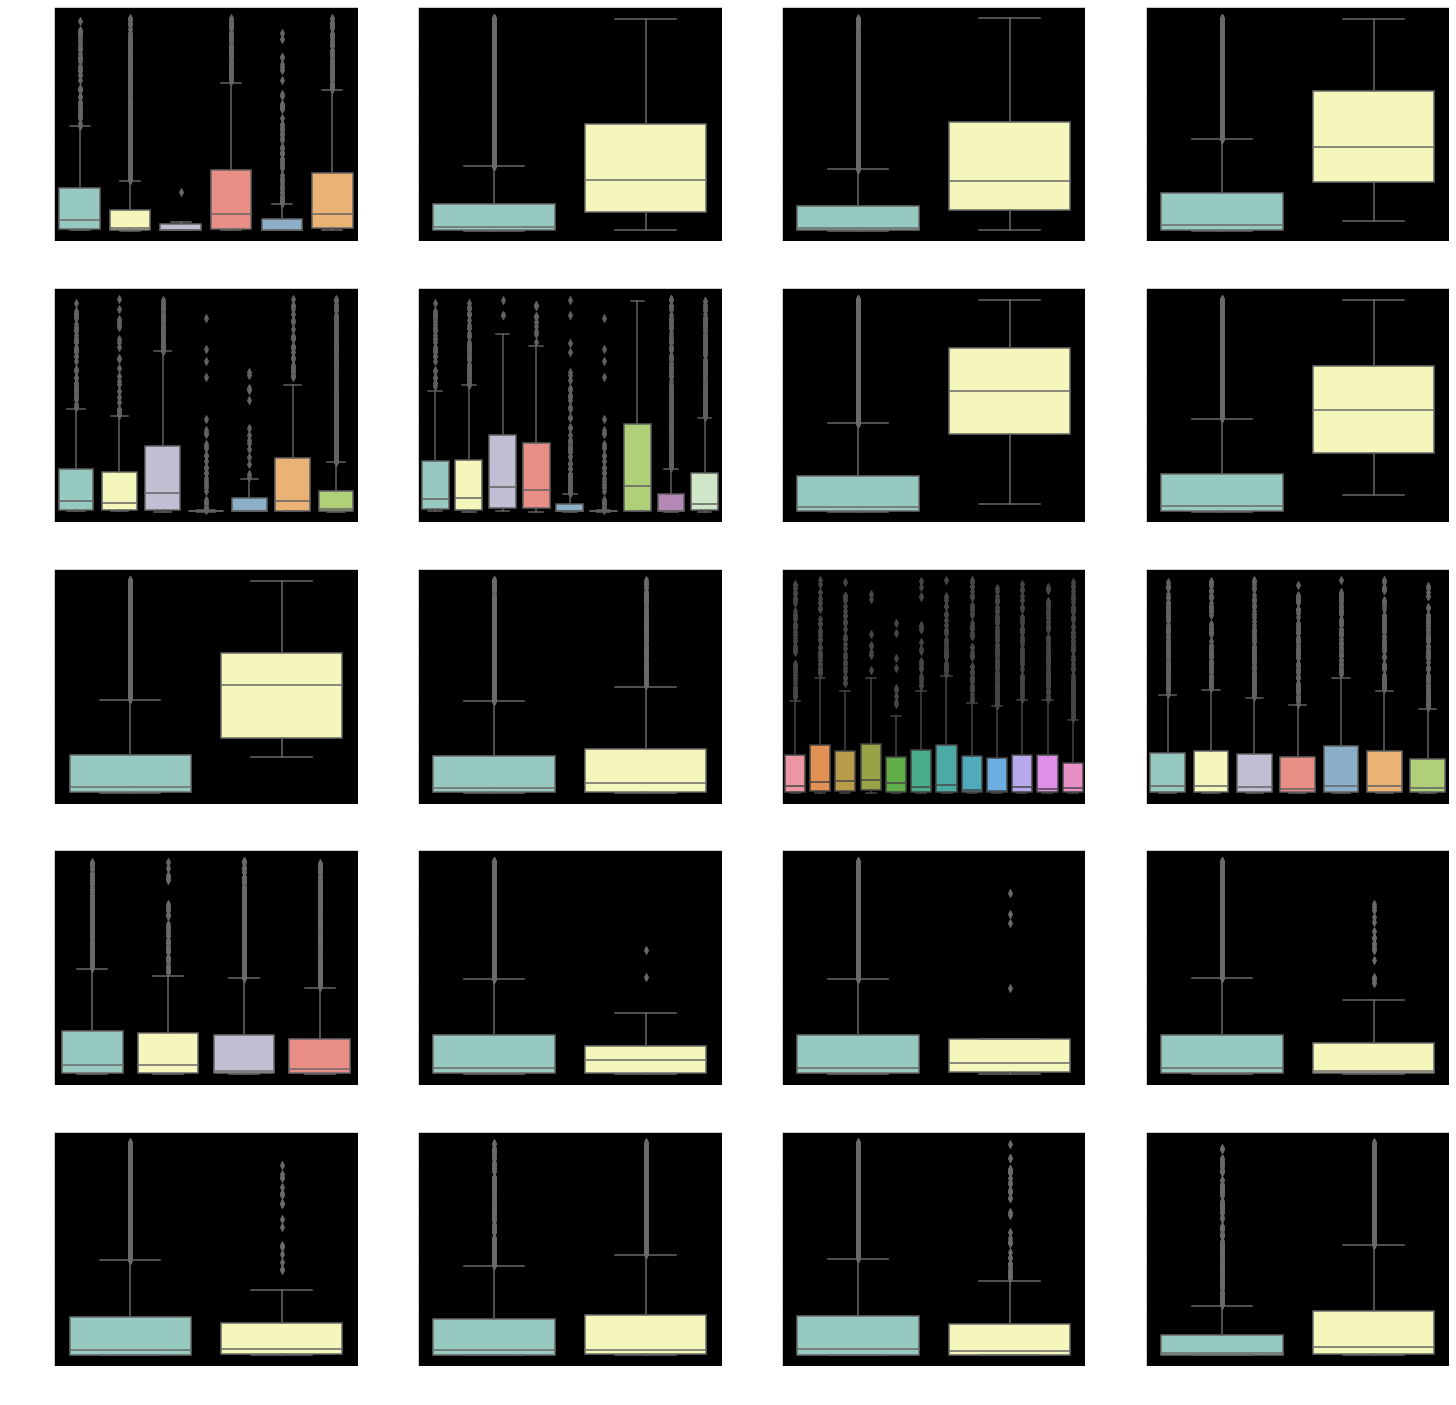

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(25, 25))

for catfeat, subplot in zip(cat_feats, ax.flatten()):
    sns.boxplot(x=catfeat, y='time_spent', data=trncopy, ax=subplot)

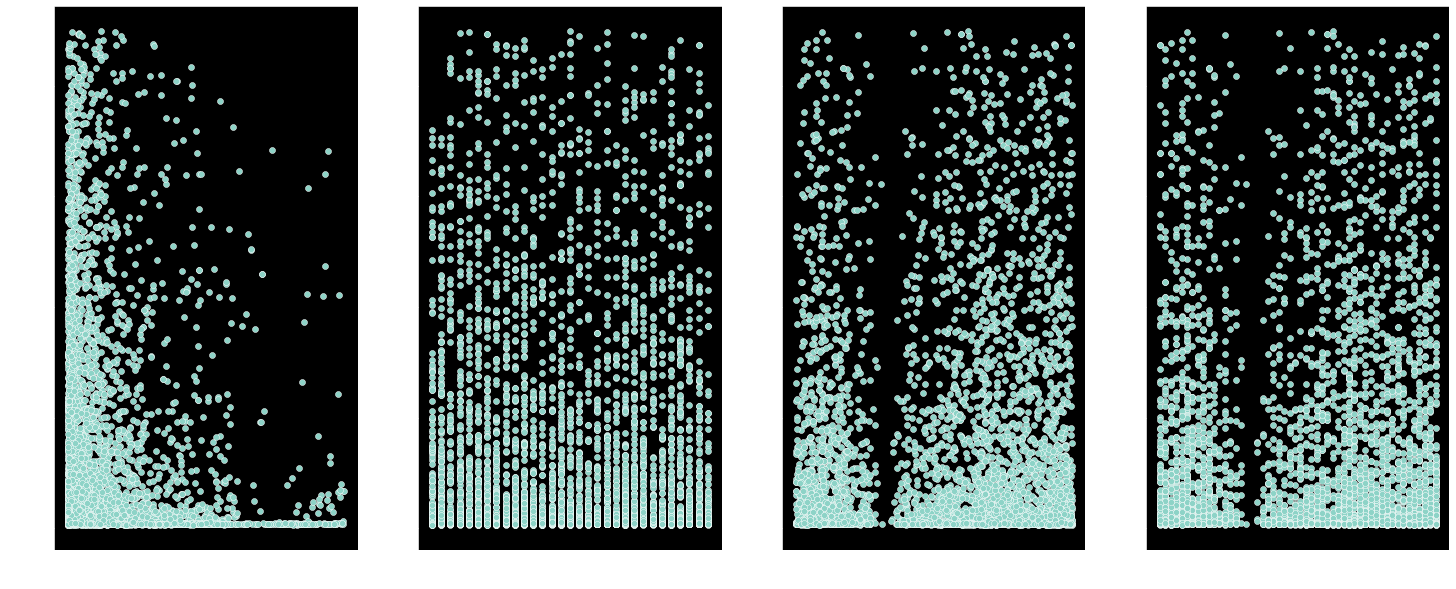

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(25, 10))

for numfeat, subplot in zip(num_feats, ax.flatten()):
    sns.scatterplot(x=numfeat, y='time_spent', data=trncopy, ax=subplot)

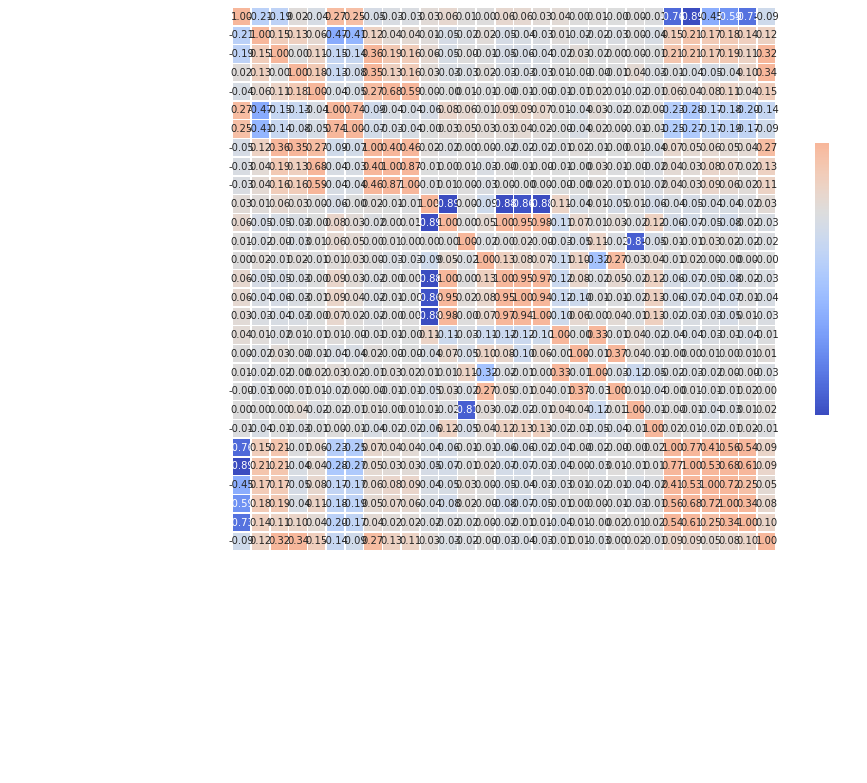

In [ ]:
corr = trncopy.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

plt.show()

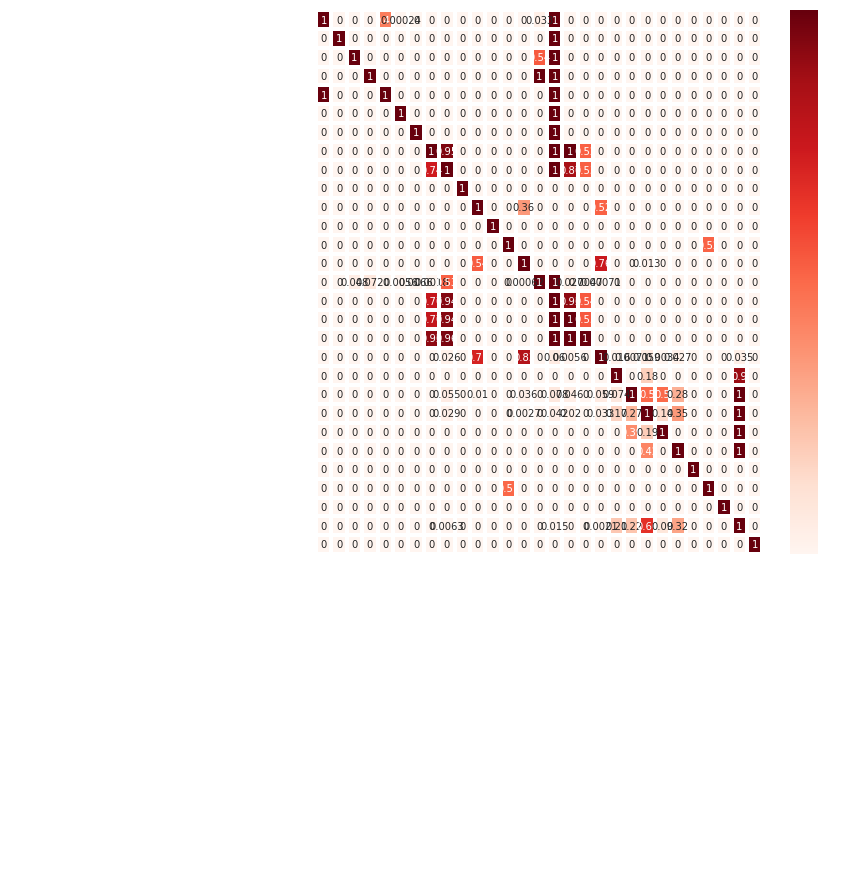

In [ ]:
df=pps.matrix(trncopy)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig, ax = plt.subplots(figsize=(10,10)) 
# sns.set(font_scale=1.3)
g=sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

### Drop cols

In [ ]:
trn.drop(['dateDay','dateDayOfyear'], axis=1, inplace=True)
tst.drop(['dateDay','dateDayOfyear'], axis=1, inplace=True)

## Baseline Test

### LGB Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(trn, y, random_state=42, test_size=0.2)
lgb_train = Dataset(X_train, y_train)
lgb_test = Dataset(X_test, y_test)

params = {
        "objective" : "regression",
        "metric" : "custom",
        "num_leaves" : 64,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 6,
        'min_data_in_leaf':300,
        "bagging_seed" : 42,
        "verbosity" : 1,
        "seed": 42,
        }

gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_test],
        early_stopping_rounds=10,
        feval=rmsle_lgbm,
        verbose_eval = 20
    )


Training until validation scores don't improve for 10 rounds.
[20]	training's rmsle: 2.19177	valid_1's rmsle: 2.25624
[40]	training's rmsle: 2.16315	valid_1's rmsle: 2.22685
[60]	training's rmsle: 2.13691	valid_1's rmsle: 2.19962
[80]	training's rmsle: 2.11269	valid_1's rmsle: 2.17422
[100]	training's rmsle: 2.09019	valid_1's rmsle: 2.15097
[120]	training's rmsle: 2.06912	valid_1's rmsle: 2.12875
[140]	training's rmsle: 2.04953	valid_1's rmsle: 2.10827
[160]	training's rmsle: 2.03093	valid_1's rmsle: 2.08881
[180]	training's rmsle: 2.01364	valid_1's rmsle: 2.07058
[200]	training's rmsle: 1.99737	valid_1's rmsle: 2.05334
[220]	training's rmsle: 1.98218	valid_1's rmsle: 2.03712
[240]	training's rmsle: 1.96803	valid_1's rmsle: 2.02208
[260]	training's rmsle: 1.95442	valid_1's rmsle: 2.00739
[280]	training's rmsle: 1.94189	valid_1's rmsle: 1.99433
[300]	training's rmsle: 1.9296	valid_1's rmsle: 1.98104
[320]	training's rmsle: 1.91882	valid_1's rmsle: 1.96975
[340]	training's rmsle: 1.90847

### Multi model test

In [15]:
baseline_models = {
    "Linear": LinearRegression(),
    "SVR" : SVR(),
    "rfreg" : RandomForestRegressor(n_jobs=-1),
    "lgb" : LGBMRegressor(n_estimators=60),
    'xgb' : XGBRegressor(objective ='reg:squarederror',n_estimators=50),
    'extratrees' : ExtraTreesRegressor(n_jobs=-1),
    'DTReg' : DecisionTreeRegressor(),
    "KNN Reg" : KNeighborsRegressor(),
    "CB REg" : CatBoostRegressor(verbose=False),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet":ElasticNet(random_state=0),
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
    "lgb2" : LGBMRegressor(n_estimators=60,reg_alpha=3,reg_lambda=0,n_jobs=-1),
    'xgb2' : XGBRegressor(objective ='reg:squarederror',n_estimators=50,n_jobs=-1,reg_alpha=3,reg_lambda=0),
    "CB REg2" : CatBoostRegressor(verbose=False,l2_leaf_reg=5),
}

In [111]:
best_models = {}
for model_name, model in baseline_models.items():
    if model_name in ['lgb','xgb']:
        estname, cvscore = kfold_cv(trn, y, model_name, model, n_splits=5, shuffle_val=True, featimp=True)
    else:
        estname, cvscore = kfold_cv(trn, y, model_name, model, n_splits=5, shuffle_val=True)
    best_models[estname] = cvscore

Average of model Linear is 1.324837840960681 and per fold scores are [1.308415895883635, 1.3486796235965588, 1.3369327684265078, 1.2916263318197334, 1.33853458507697]
Average of model SVR is 1.340050801554485 and per fold scores are [1.399252619405008, 1.2812310085889413, 1.3794406955157203, 1.362961629781052, 1.2773680544817025]
Average of model rfreg is 1.2985916542883653 and per fold scores are [1.3131372105005161, 1.3178827964165498, 1.2922489331287612, 1.2925816173875826, 1.2771077140084166]
Average of model lgb is 1.2747865588690845 and per fold scores are [1.2606074832283576, 1.266252500972213, 1.244858229838366, 1.3190158902773463, 1.2831986900291397]


,importance
SessionNo_MeanBuyerTime,329.6
session_number,295.4
diff_date,227.0
date_DayofYear,158.2
date_Day,155.6
mca_1,125.0
mca_2,119.0
Day_of_week,100.8
pur_ac_ch,72.0
DeviceDeatails_MeanBuyerTime,70.0


Average of model xgb is 1.2808340293415676 and per fold scores are [1.2412849981678968, 1.2815598075490073, 1.270564154056893, 1.285158393519576, 1.3256027934144656]


,importance
pur_ac_ch,0.591059
DeviceDeatails_MeanBuyerTime,0.089416
SessionNo_MeanBuyerTime,0.056992
session_number,0.047491
grpbydevicesession_number_mean,0.034937
diff_date,0.033012
grpbydevicedate_DayofYear_mean,0.030918
device_details,0.024281
mca_1,0.021648
mca_2,0.018621


Average of model extratrees is 1.3378265457801155 and per fold scores are [1.3327779169152885, 1.3443778479317077, 1.3781075797520361, 1.3044867592425813, 1.3293826250589649]
Average of model DTReg is 1.7518164861107466 and per fold scores are [1.7560066444035307, 1.7336404782719645, 1.811447194670844, 1.721606833062974, 1.7363812801444196]
Average of model KNN Reg is 1.3921457694818495 and per fold scores are [1.3812901123927057, 1.376844482279233, 1.4102601356296394, 1.3871415250675398, 1.4051925920401307]
Average of model CB REg is 1.2916687406895144 and per fold scores are [1.306759318229746, 1.3032492412922374, 1.254048394041928, 1.3299945790225562, 1.2642921708611052]
Average of model Ridge is 1.3238828958094142 and per fold scores are [1.304615341267529, 1.305999963916487, 1.3491095302655565, 1.3227103687430406, 1.3369792748544584]
Average of model ElasticNet is 1.5631362522255807 and per fold scores are [1.5694191380799467, 1.5676530651333862, 1.5530406504468435, 1.570712199317

In [16]:
best_models = {}
for model_name, model in baseline_models.items():
    if model_name in ['lgb','xgb']:
        estname, cvscore = kfold_cv(trn, y, model_name, model, n_splits=5, shuffle_val=True, featimp=True)
    else:
        estname, cvscore = kfold_cv(trn, y, model_name, model, n_splits=5, shuffle_val=True)
    best_models[estname] = cvscore

Average of model Linear is 1.4263385848899195 and per fold scores are [1.4630560162449413, 1.4268439141778384, 1.4020577698946524, 1.4490758750599824, 1.3906593490721837]
Average of model SVR is 1.3318164396020358 and per fold scores are [1.3380193741669182, 1.3458689878265349, 1.3501942864961491, 1.3335548801833041, 1.2914446693372723]
Average of model rfreg is 1.302162468378178 and per fold scores are [1.3702467072890105, 1.288230616148973, 1.2492226697492848, 1.305707323770686, 1.297405024932936]
Average of model lgb is 1.2747433210851047 and per fold scores are [1.2635775042833346, 1.2529963960497867, 1.3050548207418362, 1.3004688126485262, 1.2516190717020397]


,importance
SessionNo_MeanBuyerTime,338.0
session_number,310.4
diff_date,231.8
date_Day,158.8
date_DayofYear,145.8
mca_1,124.6
mca_2,120.4
Day_of_week,97.2
grpbypur_ac_chdiff_date_min,69.8
DeviceDeatails_MeanBuyerTime,59.0


Average of model xgb is 1.2799927357656458 and per fold scores are [1.3014475435935535, 1.2494344832067388, 1.3051588534727188, 1.290679814551785, 1.2532429840034327]


,importance
grpbypur_ac_chdiff_date_min,0.579579
DeviceDeatails_MeanBuyerTime,0.087618
SessionNo_MeanBuyerTime,0.052203
grpbydevicesession_number_mean,0.049436
session_number,0.043101
diff_date,0.029555
grpbydeviceDay_of_week_mean,0.023785
device_details,0.022972
grpbydevicedate_DayofYear_mean,0.022127
mca_1,0.021337


Average of model extratrees is 1.346484232526258 and per fold scores are [1.3342683394347161, 1.3804711782635968, 1.3164333386574638, 1.3866850869527172, 1.3145632193227963]
Average of model DTReg is 1.768137461692373 and per fold scores are [1.7080995587330912, 1.7818099512526777, 1.7742352198222178, 1.7749713493640842, 1.8015712292897945]
Average of model KNN Reg is 1.456997973516524 and per fold scores are [1.446436693623342, 1.4869721811426506, 1.4381352148989863, 1.455510976474774, 1.4579348014428668]
Average of model CB REg is 1.2908938614276877 and per fold scores are [1.3360539066596242, 1.3016759432031806, 1.3199338472655184, 1.2842605048330815, 1.2125451051770335]
Average of model Ridge is 1.4260387754958488 and per fold scores are [1.4293920245628777, 1.417139438074939, 1.4096502320984245, 1.4630397576676253, 1.410972425075378]
Average of model ElasticNet is 1.6469303199674752 and per fold scores are [1.6080877937093956, 1.6432378973603226, 1.6663350544384572, 1.636604649746

In [17]:
sorted_dict = {}
bmkeys = sorted(best_models, key=best_models.get)
b = {k:v for k,v in best_models.items() if k in bmkeys[:4]}
b

{'CB REg2': 1.263584265073478,
 'GradientBoostingRegressor': 1.2754135943090377,
 'lgb': 1.2747433210851047,
 'lgb2': 1.2693563066875966}

## HyPOpt

In [ ]:
# def RMSLE(y_true, y_pred):
#   return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

# rmsle = make_scorer(RMSLE, greater_is_better=False)

In [ ]:
# #Hyperparameter tuning of LightGBM Regressor using Bayesian optimization

# def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, data, targets):
#     estimator = LGBMRegressor(
#         n_estimators=n_estimators,
#         num_leaves = num_leaves,
#         min_child_samples=min_child_samples,
#         subsample = subsample,
#         random_state = 2
#     )
#     cval = cross_val_score(estimator, data, targets,
#                            scoring=rmsle, cv=5)
#     return cval.mean()

# def optimize_lgb(data, targets):
#     def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample,
#                      min_data_in_leaf,feature_fraction,bagging_fraction,
#                      max_depth,learning_rate,lambdal1):
#         return lgb_cv(
#             n_estimators=int(n_estimators),
#             num_leaves = int(num_leaves),
#             min_child_samples=int(min_child_samples),
#             subsample=subsample,
#             min_data_in_leaf=int(min_data_in_leaf),
#             feature_fraction=feature_fraction,
#             bagging_fraction=bagging_fraction,
#             max_depth=max_depth,
#             learning_rate=learning_rate,
#             lambdal1=lambdal1,
#             data=data,
#             targets=targets,
#         )

#     optimizer = BayesianOptimization(
#         f=lgb_crossval,
#         pbounds={
#             "n_estimators": (10,200),
#             "num_leaves": (2,30),
#             "min_child_samples": (2,30),
#             "subsample": (0.1,1.0),
#             'min_data_in_leaf':(20,300),
#             'feature_fraction':0.8,
#             'bagging_fraction':0.8,
#             'bagging_freq':(5,10),
#             'max_depth':(2,20),
#             'learning_rate':(0.001, 0.05),
#             "lambdal1":(0,1,0.5)
#         },
#         random_state=1234,
#         verbose=2
#     )
#     optimizer.maximize(n_iter=5, init_points=20)

#     print("Final result:", optimizer.max)

In [15]:
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVR(), param_grid, cv = 10, scoring=scorer, verbose = 3, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(trn, y) 
print(grid.best_params_) 
print(grid.best_estimator_) 

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.0min finished


{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


## Stacking models

In [78]:
%%time

model = StackingRegressor([('cb',CatBoostRegressor(verbose=False, l2_leaf_reg=5)), 
            ('lgb', LGBMRegressor(n_estimators=60,reg_alpha=3,reg_lambda=0,n_jobs=-1)),
            ('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50,n_jobs=-1,reg_alpha=3,reg_lambda=0))],
            n_jobs=-1
        )
#model = StackingRegressor([('gbr',GradientBoostingRegressor(random_state=0)),('cb',CatBoostRegressor(verbose=False)), ('lgb',  LGBMRegressor(n_estimators=50)),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)
#model = StackingRegressor([('gbr',GradientBoostingRegressor(random_state=0)), ('lgb',  LGBMRegressor(n_estimators=50)),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)
model_name  = 'Stacking Reg'
kfold_cv(trn, y, model_name, model, n_splits=5, shuffle_val=True)

Average of model Stacking Reg is 1.2616355089499227 and per fold scores are [1.272831369929031, 1.3010715354561595, 1.2705348845488724, 1.2452317441763943, 1.2185080106391561]
CPU times: user 401 ms, sys: 495 ms, total: 896 ms
Wall time: 2min 13s


## Pred

In [24]:
sub_model = SVR(C=5,gamma= 0.1, kernel='rbf')
preds = kfold_opt_cv(trn, y, tst.values, sub_model, 5, shuffle_val=True)

Score is 1.4109476036008288
Score is 1.328481362958098
Score is 1.3132372993168353
Score is 1.3889083038040433
Score is 1.4042463995225747
Average: 1.3691641938404762


In [33]:
sub_model = LGBMRegressor(n_estimators=60,reg_alpha=5,reg_lambda=5,n_jobs=-1)
preds = kfold_opt_cv(trn, y, tst.values, sub_model, 10, shuffle_val=True)

Score is 1.3266026958357473
Score is 1.2910530111585379
Score is 1.2180505675937232
Score is 1.2446315921181796
Score is 1.298480182519666
Score is 1.1763117375763692
Score is 1.1965871025244468
Score is 1.3345864267235783
Score is 1.2657130977814637
Score is 1.2574674507122858
Average: 1.2609483864543998


In [80]:
preds

array([700.28261291, 101.90514179, 262.52901333, ..., 121.94088218,
       502.48820651, 927.69716025])

In [34]:
preds

array([684.69109767,  98.10391257, 267.47971866, ...,  89.93909354,
       544.22242939, 955.70046786])

In [35]:
sub = pd.read_csv('/content/drive/MyDrive/buyer_time_pred/ParticipantData_BTPC/Sample Submission.csv')
sub.time_spent = preds
sub.to_csv('lgb.csv', index=False)
from google.colab import files
files.download("lgb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>